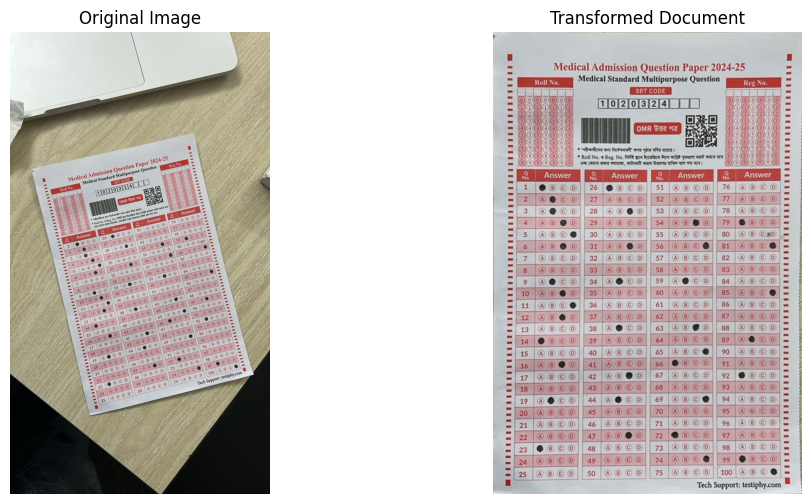

True

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_document(image):
    """
    Segment the document from the background using GrabCut and extract the vertices.
    """
    # Create a mask and initialize models
    mask = np.zeros(image.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    rect = (20, 20, image.shape[1] - 40, image.shape[0] - 40)
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    # Create a binary mask
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    segmented = image * mask2[:, :, np.newaxis]

    # Find contours and extract vertices
    contours, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    if len(contours) > 0:
        # Get the largest contour and approximate its vertices
        largest_contour = contours[0]
        perimeter = cv2.arcLength(largest_contour, True)
        vertices = cv2.approxPolyDP(largest_contour, 0.02 * perimeter, True)
        
        # Ensure the vertices are in the correct format (4 x 2)
        if len(vertices) == 4:
            vertices = vertices.reshape((4, 2))
        else:
            # If the contour has more/less than 4 vertices, use the image borders
            vertices = np.array([[10, 10], [image.shape[1]-10, 10], [image.shape[1]-10, image.shape[0]-10], [10, image.shape[0]-10]], dtype=np.float32)
    else:
        # If no contours are found, use the image borders
        vertices = np.array([[10, 10], [image.shape[1]-10, 10], [image.shape[1]-10, image.shape[0]-10], [10, image.shape[0]-10]], dtype=np.float32)

    return segmented, vertices

def crop_and_transform(image, vertices):
    """
    Crop and apply perspective transform to the segmented document.
    """
    # Reorder the vertices
    vertices = reorder_vertices(vertices)

    # Calculate the width and height of the transformed image
    (tl, tr, br, bl) = vertices
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Construct the destination points for the perspective transform
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Apply the perspective transform
    M = cv2.getPerspectiveTransform(vertices, dst)
    transformed = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return transformed

def reorder_vertices(vertices):
    """
    Reorder the vertices in the correct order (top-left, top-right, bottom-right, bottom-left).
    """
    # Sort the vertices based on their sum and difference
    reordered = np.zeros_like(vertices, dtype=np.float32)
    s = vertices.sum(axis=1)
    diff = np.diff(vertices, axis=1)

    reordered[0] = vertices[np.argmin(s)]  # Top-left
    reordered[2] = vertices[np.argmax(s)]  # Bottom-right
    reordered[1] = vertices[np.argmin(diff)]  # Top-right
    reordered[3] = vertices[np.argmax(diff)]  # Bottom-left

    return reordered

image = cv2.imread('image4.jpg')

segmented, vertices = segment_document(image)
transformed_document = crop_and_transform(image, vertices)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, ::-1])
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_document[:, :, ::-1])
plt.title("Transformed Document")
plt.axis('off')
plt.show()

cv2.imwrite('transformed_document.jpg', transformed_document)

In [2]:
import cv2

# Function to crop the image (remove upper, lower, left, and right portions)
def crop_image(image, top_fraction=0.3, bottom_fraction=0.01, left_fraction=0.0, right_fraction=0.0):
    height, width = image.shape[:2]
    
    # Calculate the pixel values to crop
    top = int(height * top_fraction)
    bottom = int(height * (1 - bottom_fraction))
    left = int(width * left_fraction)
    right = int(width * (1 - right_fraction))
    
    cropped_image = image[top:bottom, left:right]
    
    return cropped_image

# Function to split the image into four vertical parts
def split_image_into_four_vertical(image):
    height, width = image.shape[:2]
    part_width = width // 4
    
    parts = [
        image[:, 0:part_width],             # First part (left)
        image[:, part_width:2*part_width],  # Second part
        image[:, 2*part_width:3*part_width], # Third part
        image[:, 3*part_width:]             # Fourth part (right)
    ]
    
    return parts

image_path = 'transformed_document.jpg'
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Could not load image at {image_path}")
else:
    cropped_image = crop_image(image, top_fraction=0.32, bottom_fraction=0.026, left_fraction=0.06, right_fraction=0.06)
    
    parts = split_image_into_four_vertical(cropped_image)
    
    for i, part in enumerate(parts):
        part_filename = f'cropped_part_{i+1}.jpg'
        cv2.imwrite(part_filename, part)
        print(f"Saved {part_filename}")

Saved cropped_part_1.jpg
Saved cropped_part_2.jpg
Saved cropped_part_3.jpg
Saved cropped_part_4.jpg


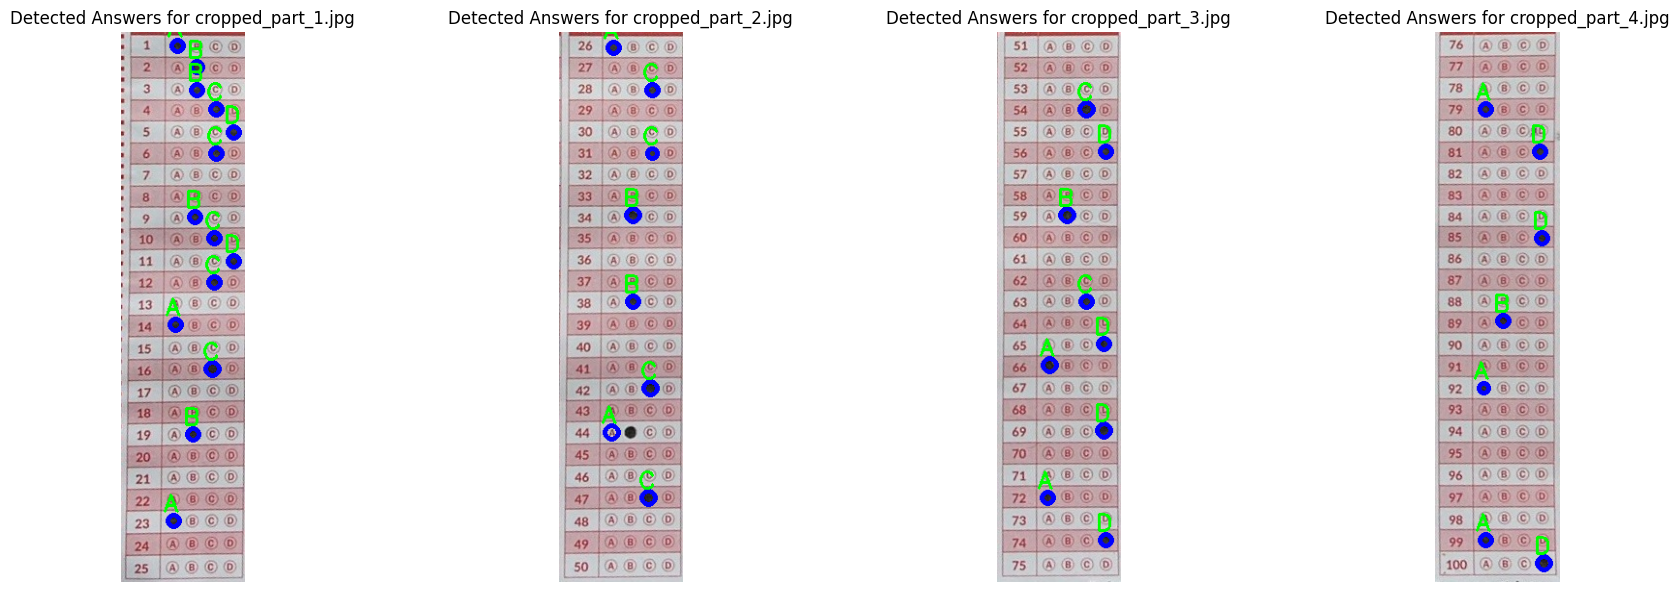


All Detected Answers:
Row 1: A
Row 2: B
Row 3: B
Row 4: C
Row 5: D
Row 6: C
Row 7: ?
Row 8: ?
Row 9: B
Row 10: C
Row 11: D
Row 12: C
Row 13: ?
Row 14: A
Row 15: ?
Row 16: C
Row 17: ?
Row 18: ?
Row 19: B
Row 20: ?
Row 21: ?
Row 22: ?
Row 23: A
Row 24: ?
Row 25: ?
Row 26: A
Row 27: ?
Row 28: C
Row 29: ?
Row 30: ?
Row 31: C
Row 32: ?
Row 33: ?
Row 34: B
Row 35: ?
Row 36: ?
Row 37: ?
Row 38: B
Row 39: ?
Row 40: ?
Row 41: ?
Row 42: C
Row 43: ?
Row 44: A
Row 45: ?
Row 46: ?
Row 47: C
Row 48: ?
Row 49: ?
Row 50: ?
Row 51: ?
Row 52: ?
Row 53: ?
Row 54: C
Row 55: ?
Row 56: D
Row 57: ?
Row 58: ?
Row 59: B
Row 60: ?
Row 61: ?
Row 62: ?
Row 63: C
Row 64: ?
Row 65: D
Row 66: A
Row 67: ?
Row 68: ?
Row 69: D
Row 70: ?
Row 71: ?
Row 72: A
Row 73: ?
Row 74: D
Row 75: ?
Row 76: ?
Row 77: ?
Row 78: ?
Row 79: A
Row 80: ?
Row 81: D
Row 82: ?
Row 83: ?
Row 84: ?
Row 85: D
Row 86: ?
Row 87: ?
Row 88: ?
Row 89: B
Row 90: ?
Row 91: ?
Row 92: A
Row 93: ?
Row 94: ?
Row 95: ?
Row 96: ?
Row 97: ?
Row 98: ?
Row 99

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_bubbles_and_answers(image, min_fill_ratio=0.2, max_fill_ratio=0.8):
    """
    Detect bubbles and determine the marked answers based on fill ratios.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Apply adaptive thresholding to enhance bubble edges
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 5
    )

    # Perform Hough Circle Transform (Detecting "bubbles")
    circles = cv2.HoughCircles(
        thresh,
        cv2.HOUGH_GRADIENT,
        dp=0.2,
        minDist=10,
        param1=10,
        param2=10,
        minRadius=4,
        maxRadius=9
    )

    result_img = image.copy()
    answers = {}
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")

        # Group circles by rows (based on y-coordinates)
        rows = {}
        for (x, y, r) in circles:
            row_found = False
            for row_y in rows:
                if abs(row_y - y) <= r * 2:  # Adjust grouping tolerance
                    rows[row_y].append((x, y, r))
                    row_found = True
                    break
            if not row_found:
                rows[y] = [(x, y, r)]

        # Process each row to find the marked answer
        for row_y in sorted(rows.keys()):
            row_bubbles = sorted(rows[row_y], key=lambda b: b[0])
            bubble_status = []

            for (x, y, r) in row_bubbles:
                # Create a mask for the bubble
                mask = np.zeros_like(gray)
                cv2.circle(mask, (x, y), r, 255, -1)
                roi = cv2.bitwise_and(thresh, thresh, mask=mask)

                # Calculate fill ratio
                total_area = np.pi * r**2
                filled_pixels = np.sum(roi == 255)
                fill_ratio = filled_pixels / total_area
                bubble_status.append((x, y, r, fill_ratio))

            # Determine the marked answer in the row (Fill ratio greater than 0.65)
            marked_bubble = None
            for idx, (x, y, r, fill_ratio) in enumerate(bubble_status):
                if fill_ratio > 0.57:
                    marked_bubble = idx
                    break

            if marked_bubble is not None:
                answer = chr(65 + marked_bubble)  # Convert index to A, B, C, D
                if answer > "D":
                    answer = "D"
                answers[row_y] = answer
                cv2.circle(result_img, (row_bubbles[marked_bubble][0], row_bubbles[marked_bubble][1]), row_bubbles[marked_bubble][2], (255, 0, 0), 3)
                cv2.putText(result_img, answer, (row_bubbles[marked_bubble][0] - 10, row_bubbles[marked_bubble][1] - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
            else:
                answers[row_y] = "?"  # No answer marked for this row

    return result_img, answers, gray, blurred, thresh

image_paths = [
    'cropped_part_1.jpg',
    'cropped_part_2.jpg',
    'cropped_part_3.jpg',
    'cropped_part_4.jpg'
]

num_images = len(image_paths)

fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 6))

if num_images == 1:
    axes = [axes]

all_answers = {}
for idx, image_path in enumerate(image_paths):
    image = cv2.imread(image_path)

    result_img, answers, gray, blurred, thresh = detect_bubbles_and_answers(image)

    all_answers[image_path] = answers

    axes[idx].imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f'Detected Answers for {image_path}')
    axes[idx].axis('off')

plt.tight_layout(pad=1.0)
plt.show()

count = 1
print("\nAll Detected Answers:")
for image_path, answers in all_answers.items():
    for row_y in sorted(answers.keys()):
        print(f"Row {count}: {answers[row_y]}")
        count += 1

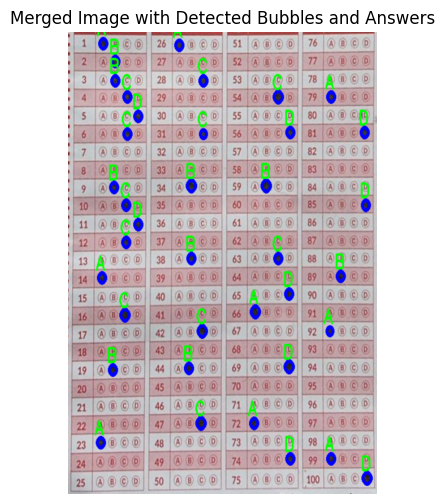

Final image saved as 'final_image_with_bubbles.jpg'


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def merge_cropped_images_into_main(original_image, cropped_images):
    height, width = original_image.shape[:2]
    merged_image = original_image.copy()

    part_width = width // 4

    for i, cropped in enumerate(cropped_images):
        cropped_resized = cv2.resize(cropped, (part_width, height))
        x_offset = i * part_width  # Horizontal offset for each part
        
        merged_image[:, x_offset:x_offset + part_width] = cropped_resized

    return merged_image

image_path = 'transformed_document.jpg'
original_image = cv2.imread(image_path)

if original_image is None:
    print(f"Error: Could not load image at {image_path}")
else:
    cropped_image = crop_image(original_image, top_fraction=0.32, bottom_fraction=0.026, left_fraction=0.06, right_fraction=0.06)
    parts = split_image_into_four_vertical(cropped_image)

    processed_parts = []
    for part in parts:
        result_img, answers, gray, blurred, thresh = detect_bubbles_and_answers(part)
        processed_parts.append(result_img)

    final_image = merge_cropped_images_into_main(original_image, processed_parts)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    plt.title('Merged Image with Detected Bubbles and Answers')
    plt.axis('off')
    plt.show()

    cv2.imwrite('final_image_with_bubbles.jpg', final_image)
    print("Final image saved as 'final_image_with_bubbles.jpg'")